In [1]:
#!pip uninstall tensorflow -y
#!pip uninstall keras -y
#!pip install tensorflow==2.6 --ignore-installed 
#!pip install keras==2.6

#!pip install  efficientnet

In [2]:
#pip install tensorflow==2.6

In [1]:
import functools
import tensorflow as tf
import cv2
from model_tools.activations.pytorch import load_preprocess_images

_mean_imagenet = tf.constant([0.485, 0.456, 0.406], shape=[1, 1, 3], dtype=tf.float32)
_std_imagenet =  tf.constant([0.229, 0.224, 0.225], shape=[1, 1, 3], dtype=tf.float32)

def load_images(image_filepaths,image_size):
    
    return np.array([load_image(image_filepath,image_size) for image_filepath in image_filepaths])

def load_image(image_filepath,image_size):
    
    original_image = cv2.imread(image_filepath)
    height, width = original_image.shape[:2]
    
    if len(original_image.shape)==2:
        original_image = gray2rgb(original_image)
    #image = transform_gen.get_transform(original_image).apply_image(original_image)
    
    image = tf.image.resize(original_image,(image_size,image_size)).numpy()
    image = tf.cast(image, tf.float32)/255.0
    image -= _mean_imagenet
    image /= _std_imagenet
    
    #inputs = {"image": image, "height": height, "width": width}
        
    return image

def load_preprocess_images(image_filepaths, image_size=256,**kwargs):
    #torch.cuda.empty_cache()
    images = load_images(image_filepaths,image_size)
    return images

preprocessing = functools.partial(load_preprocess_images, image_size=224)


In [2]:
from model_tools.activations.pytorch import PytorchWrapper
from model_tools.activations.keras import KerasWrapper

#activations_model = PytorchWrapper(identifier='my-model', model=MyModel(), preprocessing=preprocessing)

In [3]:
import glob 

models_eff =glob.glob('/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/eff*h5')

In [4]:
models_eff

['/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_logical-night_50.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_stellar-frog_8.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_drawn-sky_4.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_fearless-salad_20.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_crisp-dust_2.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_baseline.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_classic-dream-12.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_gallant-dust_1.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_solar-elevator_10.h5']

In [7]:
models =['/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/vgg_baseline.h5',
          '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/vgg_frosty_eon.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/resnet50_baseline.h5',
         '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/saliency_volcanic_monkey.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/vgg_silver_moon.h5',
         ]

In [5]:
from model_tools.activations.core import ActivationsExtractorHelper
import numpy as np
from collections import OrderedDict
class Tensorflow2Wrapper:
    def __init__(self, identifier,model,preprocessing, *args, **kwargs):
        import tensorflow as tf
        self._model = model
        
        self._extractor = ActivationsExtractorHelper(identifier=identifier, get_activations=self.get_activations,
                                                     preprocessing=preprocessing, *args, **kwargs)
        self._extractor.insert_attrs(self)

    @property
    def identifier(self):
        return self._extractor.identifier

    @identifier.setter
    def identifier(self, value):
        self._extractor.identifier = value

    def __call__(self, *args, **kwargs):  # cannot assign __call__ as attribute due to Python convention
        return self._extractor(*args, **kwargs)
    def batch_predict(self, inputs, batch_size=10):
        activations = []
        for batch_x in tf.data.Dataset.from_tensor_slices(inputs).batch(batch_size):
            #print('here')
            batch_act = self._model(batch_x)
            batch_act = np.array(batch_act, np.float16)
            activations += list(batch_act)
        return np.array(activations, np.float16)
    
    def get_activations(self, images, layer_names):
        layer_outputs = []
        for layer in layer_names: 
            activation_model = tf.keras.Model(self._model.input, self._model.get_layer(layer).output)
            #import pdb;pdb.set_trace()
            layer_outputs.append(self.batch_predict(images))  # 0 to signal testing phase
        return OrderedDict([(layer_name, layer_output) for layer_name, layer_output in zip(layer_names, layer_outputs)])
        


In [9]:
models+models_eff

['/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/vgg_baseline.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/vgg_frosty_eon.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/resnet50_baseline.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/saliency_volcanic_monkey.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/vgg_silver_moon.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_logical-night_50.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_stellar-frog_8.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_drawn-sky_4.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_fearless-salad_20.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_crisp-dust_2.h5',
 '/cifs/data/tserre_lrs

In [3]:
help( tf.keras.models.load_model)

Help on function load_model in module tensorflow.python.keras.saving.save:

load_model(filepath, custom_objects=None, compile=True, options=None)
    Loads a model saved via `model.save()`.
    
    Usage:
    
    >>> model = tf.keras.Sequential([
    ...     tf.keras.layers.Dense(5, input_shape=(3,)),
    ...     tf.keras.layers.Softmax()])
    >>> model.save('/tmp/model')
    >>> loaded_model = tf.keras.models.load_model('/tmp/model')
    >>> x = tf.random.uniform((10, 3))
    >>> assert np.allclose(model.predict(x), loaded_model.predict(x))
    
    Note that the model weights may have different scoped names after being
    loaded. Scoped names include the model/layer names, such as
    `"dense_1/kernel:0"`. It is recommended that you use the layer properties to
    access specific variables, e.g. `model.get_layer("dense_1").kernel`.
    
    Arguments:
        filepath: One of the following:
            - String or `pathlib.Path` object, path to the saved model
            - `h5py

In [7]:
import efficientnet 
efficientnet.init_tfkeras_custom_objects()

In [8]:
models_eff=['/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_baseline.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_classic-dream-12.h5',
 '/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_gallant-dust_1.h5']

In [ ]:
from brainscore import score_model
import pandas as pd
from model_tools.brain_transformation import ModelCommitment
results = []
for MODEL_NAME in models_eff:
    print(MODEL_NAME)
    model = tf.keras.models.load_model(MODEL_NAME,compile=False)
    layers = [n.name for n in model.layers[-10:]]
    activations_model = Tensorflow2Wrapper(identifier=MODEL_NAME, model=model, preprocessing=preprocessing)
    model = ModelCommitment(identifier=MODEL_NAME, activations_model=activations_model,layers = layers )
    score_v4 = score_model(model_identifier=MODEL_NAME, model=model,
                    benchmark_identifier='dicarlo.MajajHong2015public.V4-pls')
    print(score_v4)
    score_it = score_model(model_identifier=MODEL_NAME, model=model,
                    benchmark_identifier='dicarlo.MajajHong2015public.IT-pls',verbose=0)
    print(score_it)
    
    results.append([MODEL_NAME,score_it,score_v4])
    print(results)
    rdf = pd.DataFrame(results,columns=['model','score_it','score_v4'])
    rdf.to_csv('bs_score_our_models_eff_2.csv')

/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_baseline.h5


activations:   0%|          | 0/3200 [00:00<?, ?it/s]

activations:   0%|          | 0/1024 [00:00<?, ?it/s]

activations:   6%|▋         | 64/1024 [00:03<00:58, 16.29it/s]

activations:  12%|█▎        | 128/1024 [00:07<00:55, 16.01it/s]

activations:  19%|█▉        | 192/1024 [00:11<00:50, 16.47it/s]

activations:  25%|██▌       | 256/1024 [00:15<00:46, 16.68it/s]

activations:  31%|███▏      | 320/1024 [00:19<00:41, 16.81it/s]

activations:  38%|███▊      | 384/1024 [00:23<00:37, 16.87it/s]

activations:  44%|████▍     | 448/1024 [00:26<00:34, 16.93it/s]

activations:  50%|█████     | 512/1024 [00:30<00:30, 16.83it/s]

activations:  56%|█████▋    | 576/1024 [00:34<00:26, 16.90it/s]

activations:  62%|██████▎   | 640/1024 [00:38<00:22, 16.95it/s]

activations:  69%|██████▉   | 704/1024 [00:41<00:18, 16.96it/s]

activations:  75%|███████▌  | 768/1024 [00:45<00:15, 17.00it/s]

activations:  81%|████████▏ | 832/1024 [00:49<00:11, 17.00it/s]

activations:  88%|████████▊ | 896/1024 [00:53<

<xarray.Score (aggregation: 2)>
array([0.0724222 , 0.00709997])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:                   <xarray.Score (aggregation: 2)>\narray([0.23783685...
    ceiling:               <xarray.Score (aggregation: 2)>\narray([0.88377819...
    model_identifier:      /cifs/data/tserre_lrs/projects/prj_metapredictor/m...
    benchmark_identifier:  dicarlo.MajajHong2015public.V4-pls


activations:   0%|          | 0/3200 [00:00<?, ?it/s]

activations:   0%|          | 0/1024 [00:00<?, ?it/s]

activations:   6%|▋         | 64/1024 [00:03<00:56, 16.89it/s]

activations:  12%|█▎        | 128/1024 [00:07<00:53, 16.87it/s]

activations:  19%|█▉        | 192/1024 [00:11<00:49, 16.93it/s]

activations:  25%|██▌       | 256/1024 [00:15<00:45, 16.96it/s]

activations:  31%|███▏      | 320/1024 [00:18<00:41, 16.95it/s]

activations:  38%|███▊      | 384/1024 [00:22<00:37, 16.99it/s]

activations:  44%|████▍     | 448/1024 [00:26<00:33, 17.03it/s]

activations:  50%|█████     | 512/1024 [00:30<00:30, 17.04it/s]

activations:  56%|█████▋    | 576/1024 [00:34<00:26, 16.84it/s]

activations:  62%|██████▎   | 640/1024 [00:37<00:23, 16.65it/s]

activations:  69%|██████▉   | 704/1024 [00:41<00:19, 16.60it/s]

activations:  75%|███████▌  | 768/1024 [00:45<00:15, 16.72it/s]

activations:  81%|████████▏ | 832/1024 [00:49<00:11, 16.83it/s]

activations:  88%|████████▊ | 896/1024 [00:53<

<xarray.Score (aggregation: 2)>
array([0.16418858, 0.0039545 ])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:                   <xarray.Score (aggregation: 2)>\narray([0.33056346...
    ceiling:               <xarray.Score (aggregation: 2)>\narray([0.81579938...
    model_identifier:      /cifs/data/tserre_lrs/projects/prj_metapredictor/m...
    benchmark_identifier:  dicarlo.MajajHong2015public.IT-pls
[['/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_baseline.h5', <xarray.Score (aggregation: 2)>
array([0.16418858, 0.0039545 ])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:                   <xarray.Score (aggregation: 2)>\narray([0.33056346...
    ceiling:               <xarray.Score (aggregation: 2)>\narray([0.81579938...
    model_identifier:      /cifs/data/tserre_lrs/projects/prj_metapredictor/m...
    benchmark_identifier:  dicarlo.MajajHong2015public.IT-pls, <xarray.S

activations:   0%|          | 0/3200 [00:00<?, ?it/s]

activations:   0%|          | 0/1024 [00:00<?, ?it/s]

activations:   6%|▋         | 64/1024 [00:03<00:57, 16.60it/s]

activations:  12%|█▎        | 128/1024 [00:07<00:53, 16.82it/s]

activations:  19%|█▉        | 192/1024 [00:11<00:49, 16.89it/s]

activations:  25%|██▌       | 256/1024 [00:15<00:45, 16.92it/s]

activations:  31%|███▏      | 320/1024 [00:18<00:41, 16.92it/s]

activations:  38%|███▊      | 384/1024 [00:22<00:37, 16.91it/s]

activations:  44%|████▍     | 448/1024 [00:26<00:34, 16.93it/s]

activations:  50%|█████     | 512/1024 [00:30<00:30, 16.94it/s]

activations:  56%|█████▋    | 576/1024 [00:34<00:26, 16.94it/s]

activations:  62%|██████▎   | 640/1024 [00:37<00:22, 16.84it/s]

activations:  69%|██████▉   | 704/1024 [00:41<00:19, 16.69it/s]

activations:  75%|███████▌  | 768/1024 [00:45<00:15, 16.71it/s]

activations:  81%|████████▏ | 832/1024 [00:49<00:11, 16.61it/s]

activations:  88%|████████▊ | 896/1024 [00:53<

<xarray.Score (aggregation: 2)>
array([0.07845234, 0.00505912])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:                   <xarray.Score (aggregation: 2)>\narray([0.24754048...
    ceiling:               <xarray.Score (aggregation: 2)>\narray([0.88377819...
    model_identifier:      /cifs/data/tserre_lrs/projects/prj_metapredictor/m...
    benchmark_identifier:  dicarlo.MajajHong2015public.V4-pls


activations:   0%|          | 0/3200 [00:00<?, ?it/s]

activations:   0%|          | 0/1024 [00:00<?, ?it/s]

activations:   6%|▋         | 64/1024 [00:03<00:56, 17.09it/s]

activations:  12%|█▎        | 128/1024 [00:07<00:52, 17.08it/s]

activations:  19%|█▉        | 192/1024 [00:11<00:48, 17.09it/s]

activations:  25%|██▌       | 256/1024 [00:15<00:45, 17.05it/s]

activations:  31%|███▏      | 320/1024 [00:18<00:41, 17.01it/s]

activations:  38%|███▊      | 384/1024 [00:22<00:37, 16.92it/s]

activations:  44%|████▍     | 448/1024 [00:26<00:34, 16.81it/s]

activations:  50%|█████     | 512/1024 [00:30<00:30, 16.85it/s]

activations:  56%|█████▋    | 576/1024 [00:33<00:26, 16.94it/s]

activations:  62%|██████▎   | 640/1024 [00:37<00:22, 16.99it/s]

activations:  69%|██████▉   | 704/1024 [00:41<00:18, 16.87it/s]

activations:  75%|███████▌  | 768/1024 [00:45<00:15, 16.91it/s]

activations:  81%|████████▏ | 832/1024 [00:49<00:11, 16.95it/s]

activations:  88%|████████▊ | 896/1024 [00:52<

<xarray.Score (aggregation: 2)>
array([0.14510546, 0.00483009])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:                   <xarray.Score (aggregation: 2)>\narray([0.3107601 ...
    ceiling:               <xarray.Score (aggregation: 2)>\narray([0.81579938...
    model_identifier:      /cifs/data/tserre_lrs/projects/prj_metapredictor/m...
    benchmark_identifier:  dicarlo.MajajHong2015public.IT-pls
[['/cifs/data/tserre_lrs/projects/prj_metapredictor/meta_models/models/efficientnet_baseline.h5', <xarray.Score (aggregation: 2)>
array([0.16418858, 0.0039545 ])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:                   <xarray.Score (aggregation: 2)>\narray([0.33056346...
    ceiling:               <xarray.Score (aggregation: 2)>\narray([0.81579938...
    model_identifier:      /cifs/data/tserre_lrs/projects/prj_metapredictor/m...
    benchmark_identifier:  dicarlo.MajajHong2015public.IT-pls, <xarray.S

activations:   0%|          | 0/3200 [00:00<?, ?it/s]

activations:   0%|          | 0/1024 [00:00<?, ?it/s]

activations:   6%|▋         | 64/1024 [00:03<00:55, 17.25it/s]

activations:  12%|█▎        | 128/1024 [00:07<00:52, 17.23it/s]

activations:  19%|█▉        | 192/1024 [00:11<00:48, 17.22it/s]

activations:  25%|██▌       | 256/1024 [00:14<00:44, 17.22it/s]

activations:  31%|███▏      | 320/1024 [00:18<00:40, 17.22it/s]

activations:  38%|███▊      | 384/1024 [00:22<00:37, 17.21it/s]

activations:  44%|████▍     | 448/1024 [00:26<00:33, 17.21it/s]

activations:  50%|█████     | 512/1024 [00:29<00:29, 17.22it/s]

activations:  56%|█████▋    | 576/1024 [00:33<00:25, 17.24it/s]

activations:  62%|██████▎   | 640/1024 [00:37<00:22, 17.23it/s]

activations:  69%|██████▉   | 704/1024 [00:40<00:18, 17.23it/s]

activations:  75%|███████▌  | 768/1024 [00:44<00:14, 17.23it/s]

activations:  81%|████████▏ | 832/1024 [00:48<00:11, 17.22it/s]

activations:  88%|████████▊ | 896/1024 [00:52<

In [38]:
rdf.iloc[0].keys()

Index(['model', 'score_it', 'score_v4'], dtype='object')

In [14]:
parse = []
for i in range(len(rdf)):
    row =  rdf.iloc[i]
    model = row['model'].split('/')[-1]
    raw_it_m = row['score_it'].raw.values[0]
    raw_it_s = row['score_it'].raw.values[1]
    raw_v4_m = row['score_v4'].raw.values[0]
    raw_v4_s = row['score_v4'].raw.values[1]
    ceiling_it_m = row['score_it'].ceiling.values[0]
    ceiling_it_s = row['score_it'].ceiling.values[1]
    ceiling_v4_m = row['score_v4'].ceiling.values[0]
    ceiling_v4_s = row['score_v4'].ceiling.values[1]
    parse.append([model,raw_it_m,raw_it_s,raw_v4_m,raw_v4_s,ceiling_it_m,ceiling_it_s,ceiling_v4_m,ceiling_v4_s])

In [15]:
parsedf_eff = pd.DataFrame(parse,columns=['model','raw_it_m','raw_it_s','raw_v4_m','raw_v4_s','ceiling_it_m','ceiling_it_s','ceiling_v4_m','ceiling_v4_s'])

In [58]:
parsedf

,model,raw_it_m,raw_it_s,raw_v4_m,raw_v4_s,ceiling_it_m,ceiling_it_s,ceiling_v4_m,ceiling_v4_s
0,vgg_baseline.h5,0.526941,0.003884,0.413588,0.005402,0.815799,0.00145,0.883778,0.001416
1,vgg_frosty_eon.h5,0.522492,0.004914,0.395241,0.006754,0.815799,0.00145,0.883778,0.001416
2,resnet50_baseline.h5,0.492576,0.004007,0.377868,0.007480,0.815799,0.00145,0.883778,0.001416
3,saliency_volcanic_monkey.h5,0.494500,0.003973,0.380905,0.009274,0.815799,0.00145,0.883778,0.001416
4,vgg_silver_moon.h5,0.529301,0.003193,0.399481,0.007929,0.815799,0.00145,0.883778,0.001416


In [16]:
parsedf_eff

,model,raw_it_m,raw_it_s,raw_v4_m,raw_v4_s,ceiling_it_m,ceiling_it_s,ceiling_v4_m,ceiling_v4_s
0,efficientnet_logical-night_50.h5,0.340631,0.003149,0.276133,0.004997,0.815799,0.00145,0.883778,0.001416
1,efficientnet_stellar-frog_8.h5,0.309890,0.007086,0.216314,0.004746,0.815799,0.00145,0.883778,0.001416
2,efficientnet_drawn-sky_4.h5,0.308492,0.005927,0.229175,0.004841,0.815799,0.00145,0.883778,0.001416
3,efficientnet_fearless-salad_20.h5,0.321755,0.005721,0.221800,0.006474,0.815799,0.00145,0.883778,0.001416
4,efficientnet_crisp-dust_2.h5,0.308909,0.006046,0.201871,0.004713,0.815799,0.00145,0.883778,0.001416
5,efficientnet_classic-dream-12.h5,0.310577,0.004857,0.247413,0.005213,0.815799,0.00145,0.883778,0.001416
6,efficientnet_gallant-dust_1.h5,0.312843,0.004056,0.214628,0.006191,0.815799,0.00145,0.883778,0.001416
7,efficientnet_solar-elevator_10.h5,0.302471,0.005982,0.218267,0.004800,0.815799,0.00145,0.883778,0.001416


(0.3, 0.6)

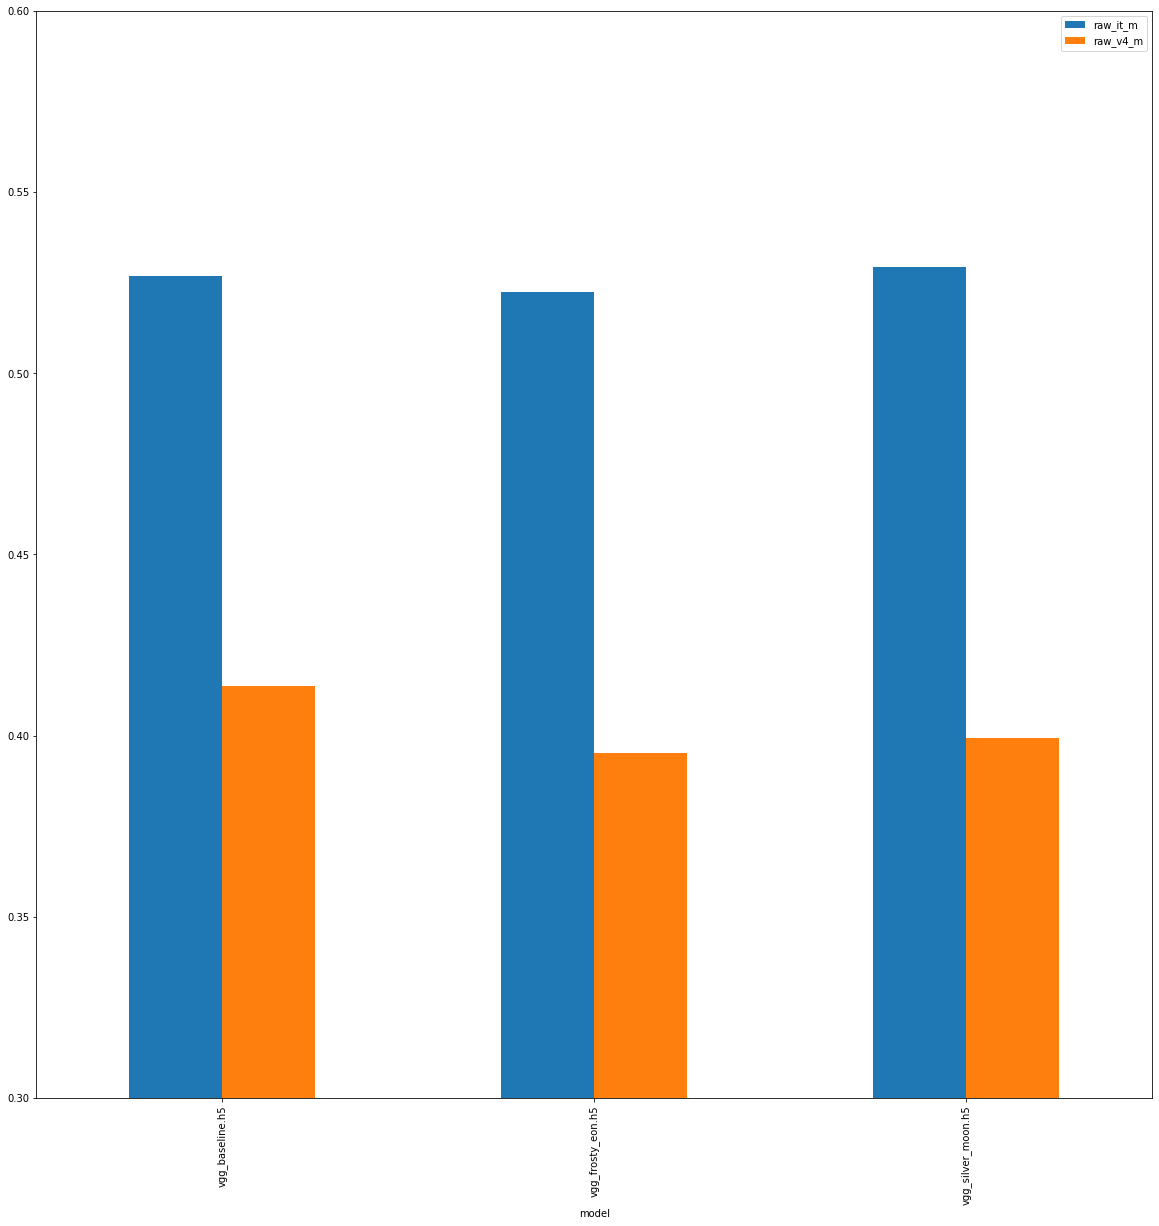

In [61]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,20)
parsedf.iloc[[0,1,4]].plot(x='model',y=['raw_it_m','raw_v4_m'],kind='bar')
plt.ylim((0.3,0.6))

(0.3, 0.6)

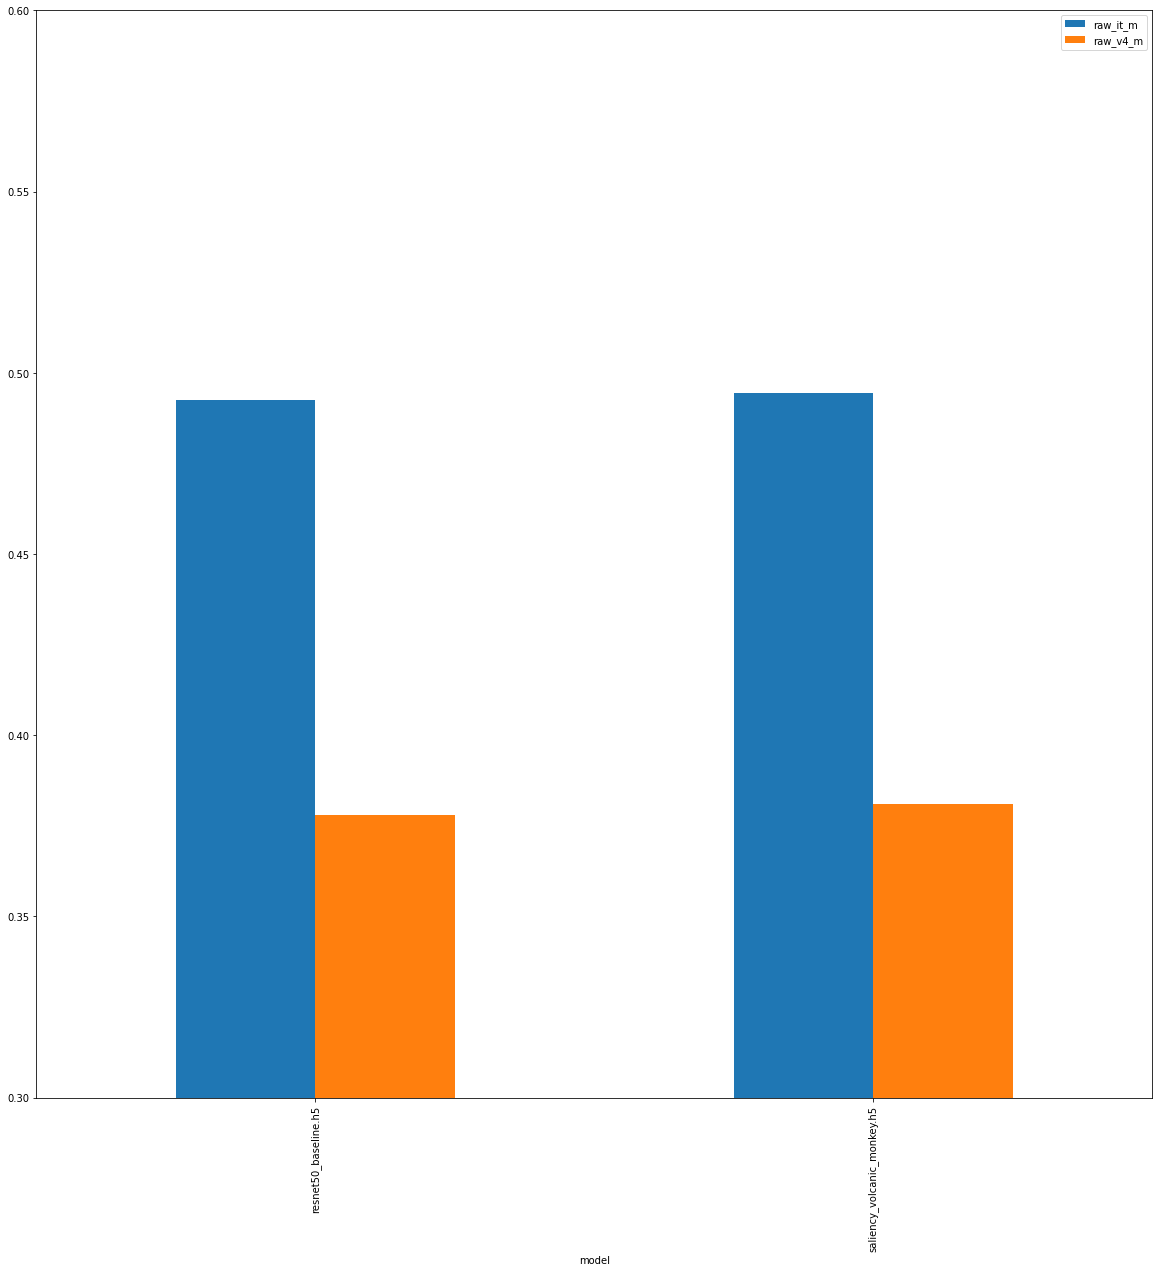

In [62]:
plt.rcParams['figure.figsize']=(20,20)
parsedf.iloc[[2,3]].plot(x='model',y=['raw_it_m','raw_v4_m'],kind='bar')
plt.ylim((0.3,0.6))

In [18]:
for r in results:
    print(r[0].split('/')[-1])

In [ ]:
from brainscore import score_model
from model_tools.brain_transformation import ModelCommitment

model = ModelCommitment(identifier='my-model', activations_model=activations_model,
                        # specify layers to consider
                        layers=['conv1', 'relu1', 'relu2'])
# The score_model will score the model on the specified benchmark.
# When the model is asked to output activations for the IT region, it will first search for the best layer
# and then only output this layer's activations.
score = score_model(model_identifier=model.identifier, model=model,
                    benchmark_identifier='dicarlo.MajajHong2015public.IT-pls')
print(score)